# Projet RCP 209 : prédiction de rendement de stock

## Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Accuracy function

In [2]:
def CFM_metrics(y_true, y_pred):
    """
    Return the metrics used for the CFM Data Challenge 2019.

    This metrics is simply the accuracy of the prediction of positive returns
    (see below for details), but based on true *returns* (y_true) and
    probabilities (of returns being positive).

    Args
        y_true: Pandas Dataframe
            target returns. Positive returns will give True, and negative ones False.

        y_pred: Pandas Dataframe
            predicted probability of positive returns.

    """
    return ((y_true.values > 0) == (y_pred.values > 0.5)).mean()

# Get data

In [3]:
data_test = pd.read_csv("data_stock\\test_input.csv", sep=',')
data_train = pd.read_csv("data_stock\\training_input.csv", sep=',')
output_train = pd.read_csv("data_stock\\training_output.csv", sep=',')

# Clean the data

In [4]:
data_train.head()

,ID,eqt_code,date,09:30:00,09:35:00,09:40:00,09:45:00,09:50:00,09:55:00,10:00:00,...,14:35:00,14:40:00,14:45:00,14:50:00,14:55:00,15:00:00,15:05:00,15:10:00,15:15:00,15:20:00
0,0,975514820,2059277756,0.378421,0.062977,-1.699955,-0.253532,0.317230,-1.394081,-1.338014,...,-0.258339,-0.193950,0.129398,0.064666,0.323250,0.193705,0.387117,0.257687,0.064357,-0.193022
1,1,975514820,661006643,-0.588441,-0.393182,0.918810,0.392393,0.195901,-0.195754,0.000000,...,0.000000,-0.260940,0.000000,-0.130601,0.130666,0.130601,0.130536,0.521881,0.260419,0.910557
2,2,975514820,2252275018,-0.974472,1.789703,-0.105310,-0.456042,0.894337,-0.341168,-0.373679,...,-0.331103,-0.236124,-0.256959,-0.229774,0.063974,-0.570371,0.133774,-0.123741,-0.764930,0.230346
3,3,975514820,901241465,-4.612982,1.746131,1.092367,-0.030626,0.996415,-1.391209,0.169799,...,0.336335,-0.185523,0.521719,-0.095356,-0.207925,0.318842,0.119798,-0.155044,0.290896,-0.058833
4,4,975514820,1213815424,-2.642804,-0.772708,-0.115318,0.145272,-0.136105,0.450894,-0.046230,...,0.631221,0.090185,-0.169416,-0.081212,-0.275152,-0.249646,0.042280,0.483204,0.394914,-0.619209


In [5]:
data_train.shape, data_test.shape, output_train.shape

((745327, 74), (319769, 74), (745327, 2))

In [6]:
data_train[["eqt_code","date"]].nunique()

eqt_code     680
date        1511
dtype: int64

# Premiere analyse

In [12]:
nb_donnee = data_train.iloc[:,3:].size
nb_nan = data_train.iloc[:,3:].isna().sum().sum()
nb_donnee,nb_nan,nb_nan/nb_donnee * 100

(52918217, 0, 0.0)

In [13]:
#we linearly interpolate the NaN for the volatility and extrapolate to 0 
data_train.iloc[:,3:57] = data_train.iloc[:,3:].interpolate(axis=1)
data_test.iloc[:,3:57]  = data_test.iloc[:,3:].interpolate(axis=1)
#we use a flat extrapolation
data_train.fillna(0,inplace=True)
data_test.fillna(0,inplace=True)

In [14]:
#check if there is some NaN
#NAs = pd.concat([data_train.isnull().sum(), data_test.isnull().sum()], axis=1, keys=['Train', 'Test'])
#NAs[NAs.sum(axis=1) > 0]

In [15]:
#drop not necessary data
data_train_clean = data_train.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
data_test_clean = data_test.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
y_train = output_train["end_of_day_return"].values

# Linear regression

In [17]:
def trainData(model,train_set=data_train_clean,test_set=data_test_clean,output=y_train):
    print("we train")
    model.fit(train_set,output)
    print("training done, we start the prediction")
    y_pred = model.predict(train_set)
    print('Train error =', round(CFM_metrics(pd.DataFrame(data=output), pd.DataFrame(data=y_pred)), 4), '%')
    print("we return the test prediction")
    return model.predict(test_set)

def sendPredictionToCfmFormat(prediction, test = data_test, fileName = 'predictions'):
    output = pd.DataFrame()
    output["ID"] = test["ID"]
    output["end_of_day_return"] = prediction
    output.to_csv(fileName+'.csv', sep=',', index=False)
    print("prediction send to"+fileName+'.csv')
    
def compare(y1,y2):
    delta = y1 * y2
    return CFM_metrics(pd.DataFrame(y1), pd.DataFrame(y2)), np.sum(delta >=0)/len(y1)*100

In [18]:
from sklearn.linear_model import LinearRegression
regrLinWeighted = LinearRegression()
y_pred_linearReg = trainData(regrLinWeighted)

we train
training done, we start the prediction
Train error = 0.5029 %
we return the test prediction


In [19]:
sendPredictionToCfmFormat(y_pred_linearReg,fileName='predictionLinReg')

prediction send topredictionLinReg.csv


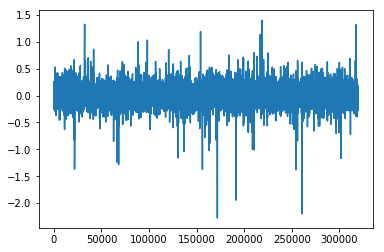

In [20]:
plt.plot(y_pred_linearReg)

## Regression with regularization : Lasso

In [21]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=.5)
y_pred_linearRegLasso = trainData(lasso)

we train
training done, we start the prediction
Train error = 0.5029 %
we return the test prediction


In [22]:
sendPredictionToCfmFormat(y_pred_linearRegLasso,fileName='predictionLinLasso')

prediction send topredictionLinLasso.csv


In [23]:
compare(y_pred_linearRegLasso, y_pred_linearReg)

(0.0002220352817189909, 50.26941323267734)

## Regression with regularisation : Ridge

In [24]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=2.0)
y_pred_linearRegRidge = trainData(ridge)

we train
training done, we start the prediction
Train error = 0.5029 %
we return the test prediction


In [25]:
sendPredictionToCfmFormat(y_pred_linearRegRidge,fileName='predictionLinRidge')

prediction send topredictionLinRidge.csv


In [26]:
compare(y_pred_linearRegRidge, y_pred_linearReg)

(0.4975341574699236, 99.99937454850219)

# Logistic regression

In [27]:
output_logistic= pd.DataFrame()
output_logistic["ID"] = output_train["ID"]
output_logistic["end_of_day_return"] = output_train["end_of_day_return"].apply(lambda row : 1 if row > 0 else -1)

In [28]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
y_pred_logistic = trainData(logistic,output=output_logistic["end_of_day_return"].values)

we train
training done, we start the prediction
Train error = 0.5217 %
we return the test prediction


In [66]:
sendPredictionToCfmFormat(y_pred_logistic,fileName='predictionLogistic')

prediction send topredictionLogistic.csv


In [67]:
compare(y_pred_logistic, y_pred_linearReg)

(0.5631721649065419, 89.06304238372074)

# SVM

## Linear

In [29]:
from sklearn.svm import LinearSVC
svc = LinearSVC(tol=1.e-5,verbose=1)
y_pred_svc = trainData(svc,output=output_logistic["end_of_day_return"].values)

we train
[LibLinear]training done, we start the prediction
Train error = 0.5222 %
we return the test prediction


C:\Users\jerpetit\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [31]:
sendPredictionToCfmFormat(y_pred_svc,fileName='predictionLogisticCV')

prediction send topredictionLogisticCV.csv


In [32]:
compare(y_pred_logistic, y_pred_svc)

(0.9399034928338894, 93.99034928338894)

## Kernel

In [ ]:
from sklearn.svm import SVC
svcGaussian = SVC(kernel='sigmoid', tol=1e-5, verbose=1)
y_pred_gaussian = trainData(svcGaussian,output=output_logistic["end_of_day_return"].values)

we train
